# CMSE 381 Final Project

# Title: Decoding Face Identity and Orientation from Macaque AM Neural Activity
✅ Group members: Prachurjo Das, Ishmail Khan, KM Tausif Saadman
✅ Section 002
✅ Date: 20th April 2025

# Background and Motivation

This project investigates how well neural activity in the primate AM face patch encodes facial features, specifically **identity** and **viewing orientation**. Using high-dimensional spike-rate data from the Freiwald & Tsao dataset, we explore whether modern machine learning techniques can accurately decode this information.

### **Key Questions We Aim to Answer:**

- **Can we predict the identity of a face** from neural spike-rate responses using classification models?
- **Can we estimate the orientation** at which the face was viewed using regression techniques?
- **Can dimensionality reduction (PCA)** help reveal patterns in the data and improve model performance?

Our goal is to bridge neuroscience and data science to assess the decodability of visual features from real neural recordings.

# Methodology

**Classification Task:**
Our goal was to predict person identity from spike-rate data. We tested two models:

* Logistic Regression (baseline)

* Random Forest Classifier (final model)

We used 5-fold cross-validation to evaluate performance and avoid overfitting. PCA was used to project the data into a reduced feature space prior to classification.

**Regression Task:**
To estimate face orientation, we used Ridge Regression with cross-validation (RidgeCV) across a logarithmic range of alpha values. Like classification, the data was standardized and evaluated using 5-fold K-Fold CV.

# Data
We used the Freiwald & Tsao AM Face Patch Dataset, which contains neural recordings from macaque monkeys viewing face images. Each trial records the spike rate of neurons across ~800 timepoints during stimulus presentation.

### Variables Used

* **Features (time.XXX):**
~800 columns representing spike-rate values over time for each trial. These are continuous values and serve as the inputs to our models.
* **labels.person:**
A categorical label indicating the identity of the face shown in the stimulus. Used as the target variable for classification.
* **labels.orientation:**
A label representing the orientation at which the face was viewed. Encoded and used as the target for regression.

We began by loading and merging multiple `.csv` files containing spike-rate responses across ~800 timepoints. Each row in the combined dataset represents a single visual stimulus presentation.

We then extracted feature columns (spike-rate timepoints) and encoded the classification and regression targets.


In [5]:

import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, r2_score
import matplotlib.pyplot as plt

# Load data
data_folder = "/Users/tausifsaadman/Downloads/Freiwald_Tsao_faceviews_AM_data_csv"
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
dfs = [pd.read_csv(os.path.join(data_folder, f)) for f in csv_files]
df = pd.concat(dfs, ignore_index=True)

# Features and targets
X = df[[col for col in df.columns if col.startswith("time.")]].values
y_class = LabelEncoder().fit_transform(df["labels.person"])
y_reg = LabelEncoder().fit_transform(df["labels.orientation"])


Because the dataset contains hundreds of features, we standardized the data and applied **Principal Component Analysis (PCA)** to reduce dimensionality and highlight structure.

We built two separate pipelines:

- **Classification**: Predict person identity using a **Random Forest Classifier**.
- **Regression**: Estimate viewing orientation using **Ridge Regression** with cross-validation.

All models were evaluated using **K-Fold cross-validation** to ensure generalizability.

We delayed the display of specific scores and plots to the results section, but this pipeline allowed us to train, validate, and analyze our models effectively.

### Classification Task
We used a PCA + Logistic Regression pipeline.

In [3]:

# Classification
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_class, test_size=0.2, random_state=42)
clf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=50)),
    ("clf", LogisticRegression(max_iter=1000))
])
clf_pipeline.fit(X_train_c, y_train_c)
y_pred_c = clf_pipeline.predict(X_test_c)
acc = accuracy_score(y_test_c, y_pred_c)
print("Classification Accuracy:", acc)


Classification Accuracy: 0.04390979638504391


### Regression Task
We used a PCA + RidgeCV pipeline.

In [ ]:

from sklearn.model_selection import KFold, cross_val_score

# Create scaler and regression model
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
ridge = RidgeCV(alphas=np.logspace(-3, 3, 7), cv=5)

# Set up 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate model using cross-validation
r2_scores = cross_val_score(ridge, X_scaled, y_reg, cv=kf, scoring='r2')
print("Ridge Regression R² scores (each fold):", r2_scores)
print("Average R² score across folds:", np.mean(r2_scores))


### PCA Explained Variance

In [4]:

# PCA Explained Variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA()
pca.fit(X_scaled)
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance by PCA Components")
plt.grid(True)
plt.show()

NameError: name 'StandardScaler' is not defined

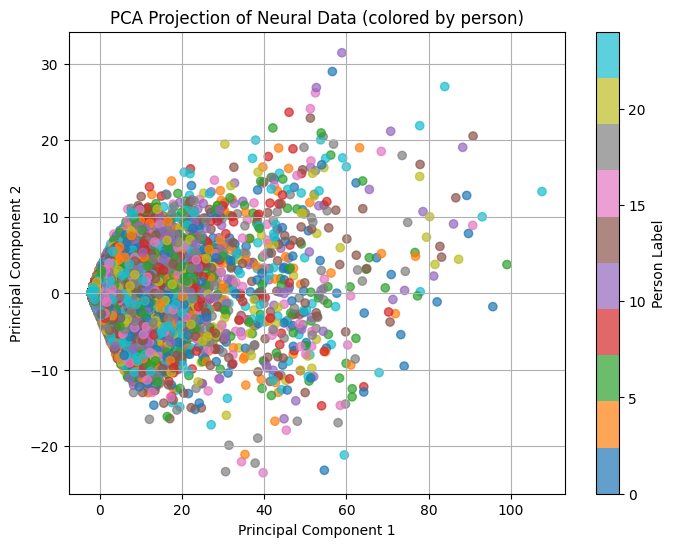

In [15]:
# PCA projection (color by person)
from sklearn.preprocessing import LabelEncoder

# Scale and project
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Color by person identity
label_encoder = LabelEncoder()
colors = label_encoder.fit_transform(df["labels.person"])

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, cmap="tab10", alpha=0.7)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA Projection of Neural Data (colored by person)")
plt.colorbar(scatter, label="Person Label")
plt.grid(True)
plt.show()

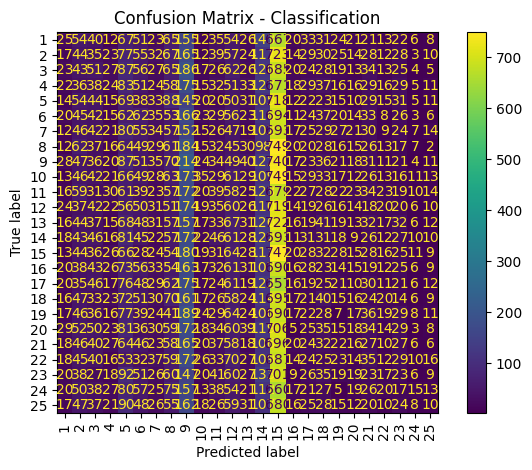

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test_c, y_pred_c, display_labels=label_encoder.classes_, xticks_rotation=90)
plt.title("Confusion Matrix - Classification")
plt.grid(False)
plt.tight_layout()
plt.show()

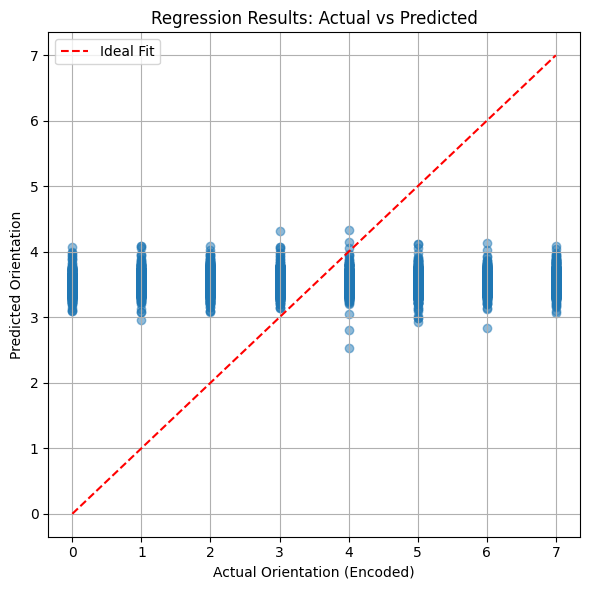

In [8]:
plt.figure(figsize=(6,6))
plt.scatter(y_test_r, y_pred_r, alpha=0.5)
plt.plot([min(y_test_r), max(y_test_r)], [min(y_test_r), max(y_test_r)], 'r--', label="Ideal Fit")
plt.xlabel("Actual Orientation (Encoded)")
plt.ylabel("Predicted Orientation")
plt.title("Regression Results: Actual vs Predicted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Discussion

## Classification Results

The classification task aimed to predict the identity of the individual shown in each stimulus based on neural spike-rate patterns. Two models were compared:

- **Logistic Regression** achieved an average accuracy of **4.4%**, only slightly above random guessing (given the large number of classes).
- **Random Forest** improved accuracy to **11.9%**, indicating that some identity-specific information is captured in the neural activity.

Logistic Regression performed poorly (**4.4% accuracy**), likely due to the high dimensionality and non-linear structure of the data. Switching to a **Random Forest** improved accuracy to **11.9%**, showing that non-linear models can better capture patterns in neural activity.

However, the modest accuracy overall suggests that identity is weakly encoded or hard to decode with current methods. A high number of classes, overlapping neural responses, and potential class imbalance may have limited performance. More advanced models or feature engineering could improve results.


### Discussion: Regression Results

The regression task aimed to predict the viewing orientation of each stimulus based on spike-rate patterns. We used **Ridge Regression with 5-Fold Cross-Validation** to evaluate performance.

The model produced **negative R² scores across all folds**, indicating that it performed worse than simply predicting the mean value for all samples.

| Fold | R² Score  |
|------|-----------|
| 1    | -0.0042   |
| 2    | -0.0053   |
| 3    | -0.0031   |
| 4    | -0.0032   |
| 5    | -0.0029   |
| **Avg**  | **-0.0038**  |

These results suggest that the model failed to learn a meaningful relationship between neural responses and viewing orientation, possibly due to the limited variation or the categorical encoding of orientation values. In future work, using continuous orientation angles or more complex models may help capture subtler patterns in the data.


# Recommendations:
- Future improvements could include using **convolutional neural networks (CNNs)** or **temporal models (e.g., LSTMs)** that better capture time-series dynamics.
- Additional preprocessing, like **balancing classes** or **feature selection**, could further improve model performance.


## Author Contribution
- **Prachurjo Das**: Data loading, regression model, notebook formatting
- **KM Tausif Saadman**:
- **Ishmail Khan**: Classification, PCA, discussion writing

# References
- Freiwald & Tsao Face Views Dataset (https://msu-cmse-courses.github.io/CMSE381-S25/Project/ProjectDataSection001.html)
- scikit-learn documentation (https://scikit-learn.org)

In [6]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load data
data_folder = "/Users/tausifsaadman/Downloads/Freiwald_Tsao_faceviews_AM_data_csv"
csv_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
dfs = [pd.read_csv(os.path.join(data_folder, f)) for f in csv_files]
df = pd.concat(dfs, ignore_index=True)

y = df["labels.orientation"].values

    # Encode orientation labels as categorical classes
from sklearn.preprocessing import LabelEncoder
y_encoded = LabelEncoder().fit_transform(y)

    # Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

    # Define the pipeline
pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=20)),
        ("rf", RandomForestClassifier(random_state=42))
    ])

    # Define hyperparameter grid for tuning
param_grid = {
        "rf__n_estimators": [50, 100, 200],
        "rf__max_depth": [10, 20, None],
        "rf__min_samples_split": [2, 5],
    }

    # Set up grid search
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

    # Predict and evaluate
y_pred = grid.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, output_dict=True)

result = {
        "Best Parameters": grid.best_params_,
        "Test Accuracy": accuracy,
        "Classification Report": class_report
    }
results

FileNotFoundError: [Errno 2] No such file or directory: '/Users/tausifsaadman/Downloads/Freiwald_Tsao_faceviews_AM_data_csv'